In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Parameters
train_path = "Train"
test_path = "Test"
train_csv = "Train.csv"
test_csv = "Test.csv"
label_csv = "labels.csv"
batch_size_val = 30
steps_per_epoch_val = 1000
epochs_val = 10
imageDimensions = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2


In [3]:
# Function to read ROI and image path data from CSV
def read_csv_data(csv_file):
    data = pd.read_csv(csv_file)
    images = []
    classNo = []
    for index, row in data.iterrows():
        img = cv2.imread(row['Path'])
        roi_x1, roi_y1, roi_x2, roi_y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
        img_roi = img[roi_y1:roi_y2, roi_x1:roi_x2]
        img_roi_resized = cv2.resize(img_roi, (imageDimensions[0], imageDimensions[1]))
        images.append(img_roi_resized)
        classNo.append(row['ClassId'])
    return np.array(images), np.array(classNo)

# Read train data
X_train, y_train = read_csv_data(train_csv)

# Read test data
X_test, y_test = read_csv_data(test_csv)

# Split train data
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# Preprocessing
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

X_train = np.array([preprocessing(img) for img in X_train])
X_validation = np.array([preprocessing(img) for img in X_validation])
X_test = np.array([preprocessing(img) for img in X_test])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Data Augmentation
dataGen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

dataGen.fit(X_train)

# Model
model = Sequential()
model.add(Conv2D(60, (5, 5), input_shape=(imageDimensions[0], imageDimensions[1], 1), activation='relu'))
model.add(Conv2D(60, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=steps_per_epoch_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    shuffle=1)

# Evaluation
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# Save Model
model.save("rcnn_model_with_roi.h5")

C:\Users\c23049589\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


C:\Users\c23049589\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 342s 332ms/step - accuracy: 0.3698 - loss: 2.3225 - val_accuracy: 0.9652 - val_loss: 0.1388
Epoch 2/10
  46/1000 ━━━━━━━━━━━━━━━━━━━━ 6:36 416ms/step - accuracy: 0.7666 - loss: 0.7621

C:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.7819 - loss: 0.7037 - val_accuracy: 0.9705 - val_loss: 0.1563
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 326s 326ms/step - accuracy: 0.8220 - loss: 0.5898 - val_accuracy: 0.9769 - val_loss: 0.0778
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.8738 - loss: 0.4271 - val_accuracy: 0.9846 - val_loss: 0.0631
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 346s 328ms/step - accuracy: 0.8839 - loss: 0.3772 - val_accuracy: 0.9787 - val_loss: 0.0631
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.9008 - loss: 0.3218 - val_accuracy: 0.9903 - val_loss: 0.0393
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 461s 461ms/step - accuracy: 0.9127 - loss: 0.2994 - val_accuracy: 0.9966 - val_loss: 0.0195
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9141 - loss: 0.2974 - val_accuracy: 0.9941 - val_loss: 0.0285
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 365s 347ms/step - accuracy: 0.9288 - lo

Test Score: 0.09538308531045914
Test Accuracy: 0.974663496017456


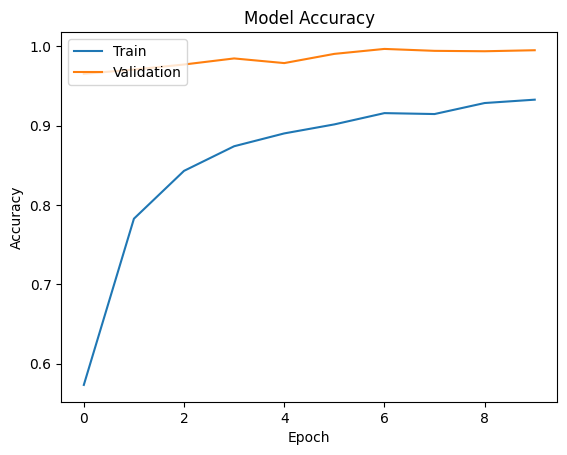

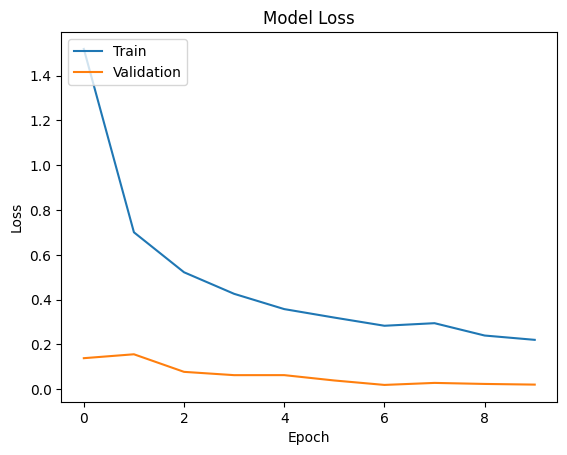

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [7]:
test_result = model.evaluate(X_test, y_test
print("Test loss : ", test_result[0])

395/395 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.9752 - loss: 0.0940
Test loss :  0.09538308531045914


In [12]:
# Predict the probabilities for each class for the test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred))


395/395 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.97      1.00      0.98       720
           2       0.97      1.00      0.99       750
           3       0.99      0.93      0.96       450
           4       0.98      0.98      0.98       660
           5       0.94      0.96      0.95       630
           6       0.97      0.99      0.98       150
           7       1.00      1.00      1.00       450
           8       0.99      1.00      0.99       450
           9       0.97      1.00      0.98       480
          10       0.99      0.97      0.98       660
          11       0.98      0.92      0.95       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      0.80      0.89       210
          16       0.99      1.00    

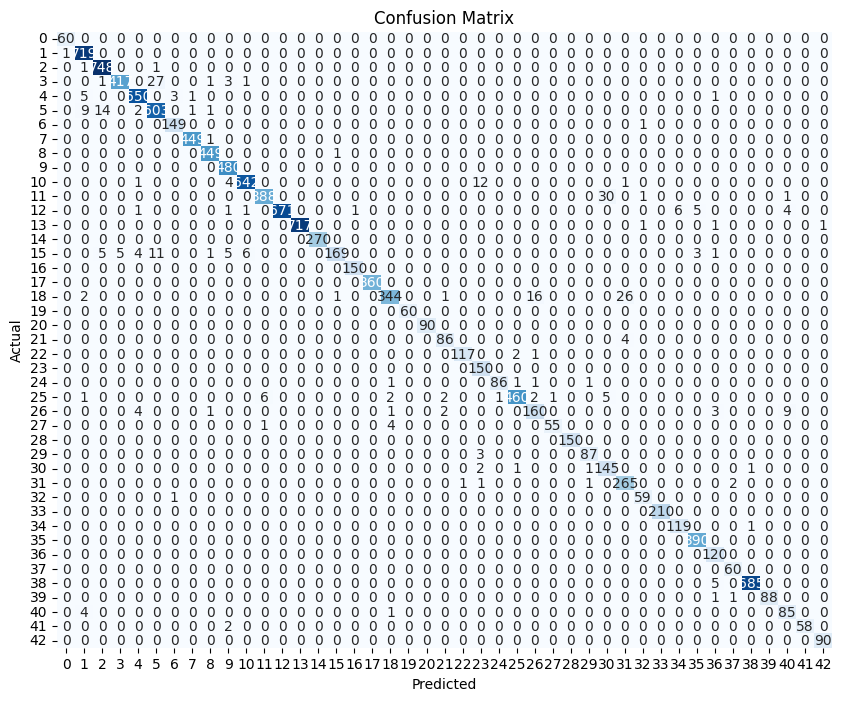

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
